# Supplemental Figure S11: Non-WC and WC overlaps with different normalization methods

# Setup

## imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from dms_3d_features.plotting import *

## extra functions

In [3]:
def fit_logistic_regression(df):
    df = df.copy()
    df = df.query("r_type == 'Flank-WC' or r_type == 'NON-WC'").copy()
    df["r_type_simple"] = df["r_type"].replace("Flank-WC", "WC")
    df["r_type_binary"] = df["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
    model = LogisticRegression()
    model.fit(df[["ln_r_data"]], df["r_type_binary"])
    # Compute probabilities for the original data
    df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
    # Display the probabilities
    df.sort_values("prob_WC", ascending=False)[
        ["ln_r_data", "r_type_simple", "prob_WC"]
    ]
    # Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
    df["abs_diff"] = (df["prob_WC"] - 0.50).abs()
    # Find the index of the minimum difference
    min_index = df["abs_diff"].idxmin()
    # Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
    closest_row = df.loc[min_index]
    return closest_row["ln_r_data"]


def plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold=-5.45):
    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'Flank-WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )

    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    return ax


def get_avg_reference_hairpin_reactivity_from_row(row):
    # Create an object from sequence and structure
    struct = SecStruct(row["sequence"], row["structure"])

    # Extract hairpin motifs from the object
    hairpins = struct.get_hairpins()
    if len(hairpins) == 0:
        print(f"Warning: No hairpins found for {row['name']}")
        return None

    hairpin = hairpins[0]
    pos1 = hairpins[0].positions[2]
    pos2 = hairpins[0].positions[5]
    return (row["data"][pos1] + row["data"][pos2]) / 2


def compute_distribution_splits(df, threshold, column="reac_ratio"):
    # Extract data
    blue = df.query("r_type == 'Flank-WC'")[column].dropna()
    orange = df.query("r_type == 'NON-WC'")[column].dropna()

    # Percentage of orange (NON-WC) to the left of threshold
    orange_left_pct = np.mean(orange < threshold) * 100

    # Percentage of blue (Flank-WC) to the right of threshold
    blue_right_pct = np.mean(blue > threshold) * 100

    return orange_left_pct, blue_right_pct


def plot_flank_wc_nonwc_overlap_with_percentages(df, ax):
    """
    Plots the overlap of Flank-WC and Non-WC distributions with threshold and annotates percentages.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data to plot.
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    """
    threshold = fit_logistic_regression(df)
    plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold)
    ax.set_yticks([0, 5000, 10000], labels=["0", "5", "10"])
    # add_legend(ax, ["Flank-WC", "Non-WC"])
    orange_left, blue_right = compute_distribution_splits(
        df, threshold, column="ln_r_data"
    )
    ax.set_xlabel("ln(Normalized Reactivity)", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    # Add orange_left in top left, blue_right in top right, both bold Arial and colored
    ax.text(
        0.01,
        0.98,
        f"{orange_left:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:orange",
        va="top",
        ha="left",
    )
    ax.text(
        0.99,
        0.98,
        f"{blue_right:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:blue",
        va="top",
        ha="right",
    )

## load data

In [4]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [5]:
df_nomod_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_nomod_normalized_residues.json"
)
df_nomod_norm_res = df_nomod_norm_res.query("ln_r_data > -9")

df_denature_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_denature_normalized_residues.json"
)
df_denature_norm_res = df_denature_norm_res.query("ln_r_data > -9")

df_res = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_res["ln_r_data"] = np.log(df_res["r_data"])
df_res["ln_r_data"] = df_res["ln_r_data"].replace(-np.inf, -9.8)
df_res = df_res.query("ln_r_data > -9")

df_denature_res = pd.read_json(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_denature_residues_2000.json"
)
df_denature_res["ln_r_data"] = df_denature_res["ln_r_data"].replace(-np.inf, -9.8)

df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plotting

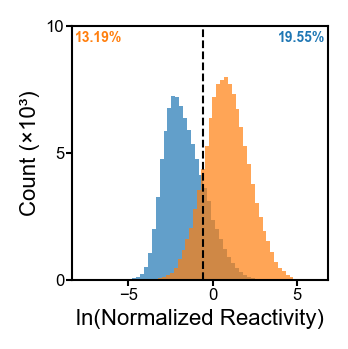

In [6]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax)

In [7]:
df_res_norm_by_avg = df_res.copy()
df_res_norm_by_avg["norm_r_data"] = df_res_norm_by_avg["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    avg = np.mean(row["data"])
    df_res_norm_by_avg.loc[g.index, "norm_r_data"] = g["r_data"] / avg

df_res_norm_by_avg["ln_norm_r_data"] = np.log(df_res_norm_by_avg["norm_r_data"])
df_res_norm_by_avg.loc[
    np.isinf(df_res_norm_by_avg["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_avg = df_res_norm_by_avg.query("ln_norm_r_data > -9")
df_res_norm_by_avg["ln_r_data"] = df_res_norm_by_avg["ln_norm_r_data"]

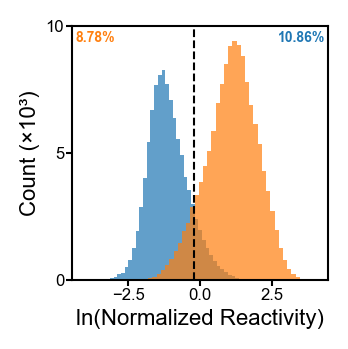

In [8]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax)

In [9]:
df_res_norm_by_ref_hp = df_res.copy()
df_res_norm_by_ref_hp["norm_r_data"] = df_res_norm_by_ref_hp["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    ref_a_avg = get_avg_reference_hairpin_reactivity_from_row(row)
    df_res_norm_by_ref_hp.loc[g.index, "norm_r_data"] = g["r_data"] / ref_a_avg

df_res_norm_by_ref_hp["ln_norm_r_data"] = np.log(df_res_norm_by_ref_hp["norm_r_data"])
df_res_norm_by_ref_hp.loc[
    np.isinf(df_res_norm_by_ref_hp["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_ref_hp = df_res_norm_by_ref_hp.query("ln_norm_r_data > -9")
df_res_norm_by_ref_hp["ln_r_data"] = df_res_norm_by_ref_hp["ln_norm_r_data"]

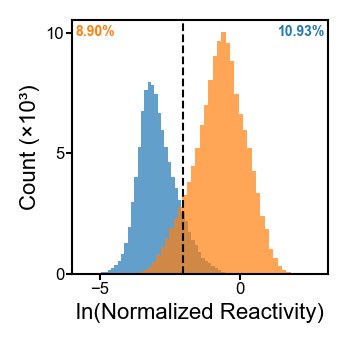

In [10]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax)

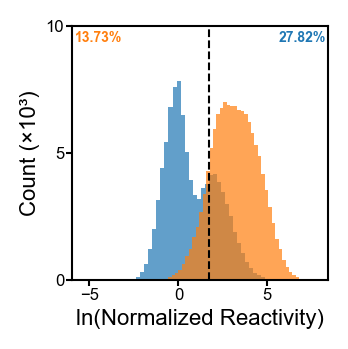

In [11]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax)

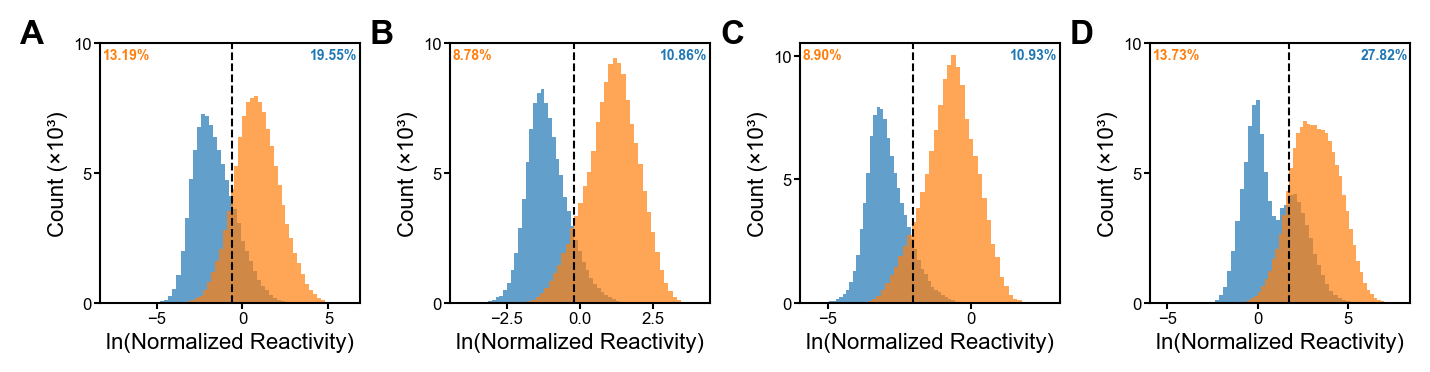

In [12]:
fig_size = (7, 6)
layout = (1, 4)
subplot_size = (1.3, 1.3)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
ax1 = fig.add_axes(coords_list[0])
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax4)
add_subplot_labels(fig, coords_list)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s11.png",
    dpi=600,
    bbox_inches="tight",
)